In [1]:
import os 
import sys
import torch 
import torch.nn as nn
import open3d as o3d
import numpy as np
import json
from sklearn.metrics.pairwise import cosine_similarity

sys.path.append(os.path.abspath('/home/shirshak/00_teeth_similarity_matching/models'))
sys.path.append(os.path.abspath('/home/shirshak/00_teeth_similarity_matching/src/data_preprocess'))
from dgcnn import DGCNN
from load_obj_save_pcd import preprocess_and_save_obj
import plotly.io as pio
import plotly.graph_objects as go
import io
import matplotlib.pyplot as plt
from PIL import Image
import re

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
num_classes = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DGCNN(output_channels=num_classes)
# model

In [3]:
checkpoint = torch.load("/home/shirshak/00_teeth_similarity_matching/model_ckpt/best_model.pth")
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [4]:
# Removing last layers with Identity which will not perform any operations 
model.dp2 = nn.Identity()
model.linear3 = nn.Identity()
model = model.to(device)
model

DGCNN(
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=Fal

In [5]:
# Code taken from src.data_preprocess.load_obj_save_pcd.preprocess_and_save_obj
# but obj not saved 
def preprocess_obj(file_path, num_points=2048):
    """ Preprocess the OBJ file into a point cloud and save as a tensor. """
    # Preprocess the point cloud
    mesh = o3d.io.read_triangle_mesh(file_path)
    pcd = mesh.sample_points_uniformly(number_of_points=num_points)

    #normalize PCD
    points = np.asarray(pcd.points)
    centroid = np.mean(points, axis=0)
    points -= centroid  # Centering
    max_distance = np.max(np.linalg.norm(points, axis=1))
    points /= max_distance  # Scaling
    pcd.points = o3d.utility.Vector3dVector(points)

    points = np.asarray(pcd.points)
    points = torch.tensor(points, dtype=torch.float32)
    
    return points

In [6]:
def compute_voxel_dice_score(voxel_grid1, voxel_grid2):
    """
    Compute the Dice score between two voxel grids.
    """
    # Get the set of voxel coordinates for each voxel grid
    voxels1 = set([tuple(voxel.grid_index) for voxel in voxel_grid1.get_voxels()])
    voxels2 = set([tuple(voxel.grid_index) for voxel in voxel_grid2.get_voxels()])
    
    # Compute intersection of the voxel sets
    intersection = voxels1.intersection(voxels2)
    
    # Dice Score = 2 * |A ∩ B| / (|A| + |B|)
    dice_score = (2 * len(intersection)) / (len(voxels1) + len(voxels2)) if (len(voxels1) + len(voxels2)) > 0 else 0
    
    return dice_score

In [7]:
def load_data_from_json(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    
    # Convert feature vectors back to numpy arrays
    for entry in data:
        entry['feature_vector'] = np.array(entry['feature_vector'])
    
    return data

In [8]:
# target_obj_path = # TODO 
# target_obj_point_cloud_orig = preprocess_obj() #TODO 

In [9]:
target_obj_point_cloud = torch.load("/home/shirshak/Teeth3DS_individual_teeth/pcd_tensors_test/01ENPFHF_lower_fid31.pt").transpose(0, 1).unsqueeze(0)
# Transpose to change shape from (2048, 3) to (3, 2048), then unsqueeze for adding batch for loading in to the model 
target_obj_point_cloud = target_obj_point_cloud.to(device)

In [10]:
target_obj_point_cloud.shape

torch.Size([1, 3, 2048])

In [11]:
model.eval()
with torch.no_grad():
    target_tooth_feature_vector_dim256 = model(target_obj_point_cloud).cpu().numpy()

In [13]:
tooth_examples_feature_vectors = load_data_from_json('/home/shirshak/00_teeth_similarity_matching/feature_info.json')

In [14]:
def find_top_n_similar_feature_vectors(query_vector, data, top_n=10):
    all_feature_vectors = np.array([entry['feature_vector'] for entry in data])
    similarities = cosine_similarity(query_vector, all_feature_vectors).flatten()
    top_n_indices = np.argsort(-similarities)[:top_n]
    similarities = [similarities[index] for index in top_n_indices]
    return top_n_indices, similarities

In [15]:
top_10_indices, simil = find_top_n_similar_feature_vectors(target_tooth_feature_vector_dim256, tooth_examples_feature_vectors, top_n=10)

In [16]:
def get_pid_fid_from_indices(indices, data):
    pids = []
    fids = []
    for idx in indices:
        thumbnail_path = data[idx]['mesh_location']
        # print(thumbnail_path)
        # Extract labels
        # print(thumbnail_path.split('/')[-1].split('_')[0])#.split('_')[-1].split('.')[0].split('d')[-1]))
        # pids.append(int(thumbnail_path.split('/')[-1].split('_')[-1].split('.')[0].split('d')[-1]))
        pids.append(thumbnail_path.split('/')[-1].split('_')[0])
        fids.append(thumbnail_path.split('/')[-1].split('.')[0].split('_')[-1])
    return pids, fids

In [17]:
pids, fids = get_pid_fid_from_indices(top_10_indices, tooth_examples_feature_vectors)

In [18]:
pids, fids

(['01ENPFHF',
  'QTDZUUZV',
  '015SUFFX',
  'E1OLNXQ5',
  '3XXKPMWE',
  'IUIE4BYI',
  'FJS5HCDU',
  '1QI2XWMD',
  'X9OQZ131',
  '0145NKWZ'],
 ['fid31',
  'fid31',
  'fid31',
  'fid31',
  'fid31',
  'fid31',
  'fid31',
  'fid31',
  'fid31',
  'fid31'])

In [19]:
def mesh_to_voxel_grid(mesh, voxel_size=2):
    """Convert a mesh to a voxel grid using Open3D."""
    return o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=voxel_size)

def load_voxel_grid(file_path, voxel_size=2):
    """Load and preprocess a single obj file into a voxel grid."""
    mesh = o3d.io.read_triangle_mesh(file_path)
    return mesh_to_voxel_grid(mesh, voxel_size)

In [20]:
original_mesh = load_voxel_grid("/home/shirshak/Teeth3DS_individual_teeth/individual_teeth/01ENPFHF_lower_fid31.obj")

In [21]:
dice_scores = []
for pid, fid in zip(pids, fids):

    if int(fid.split("fid")[-1]) < 30:
        category = 'upper'
    else:
        category = 'lower'

    base_path = "/home/shirshak/Teeth3DS_individual_teeth/individual_teeth"
    sim_obj_path = f"{base_path}/{pid}_{category}_{fid}.obj"
    
    similar_mesh = load_voxel_grid(sim_obj_path)
    dice_scores.append(compute_voxel_dice_score(original_mesh, similar_mesh))

In [22]:
sim_obj_path

'/home/shirshak/Teeth3DS_individual_teeth/individual_teeth/0145NKWZ_lower_fid31.obj'

In [23]:
print(dice_scores)

[1.0, 0.8888888888888888, 0.85, 0.7469879518072289, 0.868421052631579, 0.8505747126436781, 0.8974358974358975, 0.925, 0.875, 0.8470588235294118]


In [24]:
def visualize_mesh(mesh, color=None):
    if not mesh.has_vertex_normals():
        mesh.compute_vertex_normals()
    if not mesh.has_triangle_normals():
        mesh.compute_triangle_normals()

    triangles = np.asarray(mesh.triangles)
    vertices = np.asarray(mesh.vertices)

    # Set the color to white if no color is provided
    if color is None:
        color = np.array([255, 255, 255]) / 255.0  # Normalize the color to [0, 1]

    # Apply the color to all vertices
    colors = np.tile(color, (vertices.shape[0], 1))

    # Create a figure
    fig = go.Figure(
        data=[
            go.Mesh3d(
                x=vertices[:, 0],
                y=vertices[:, 1],
                z=vertices[:, 2],
                i=triangles[:, 0],
                j=triangles[:, 1],
                k=triangles[:, 2],
                vertexcolor=colors,  # Set the vertex colors
                opacity=1
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode='auto',  # Ensures aspect ratio is correct
                camera=dict(
                    eye=dict(x=1, y=1, z=1)  # Adjust camera position
                )
            )
        )
    )

    # Set axis limits to remove white space
    x_limits = [vertices[:, 0].min(), vertices[:, 0].max()]
    y_limits = [vertices[:, 1].min(), vertices[:, 1].max()]
    z_limits = [vertices[:, 2].min(), vertices[:, 2].max()]

    fig.update_layout(scene=dict(
        xaxis=dict(range=x_limits),
        yaxis=dict(range=y_limits),
        zaxis=dict(range=z_limits)
    ))

    return fig

In [25]:
def convert_plotly_fig_to_image(fig):
    # Convert the Plotly figure to a static image using plotly.io
    image_data = pio.to_image(fig, format='png')
    image = Image.open(io.BytesIO(image_data))
    return image

In [26]:
def display_grid_with_top_matches(original_mesh_image,og_id, top_n_indices, data,similarities_corpus, output_file = None):
    num_matches = len(top_n_indices)
    
    # Create a figure with a grid that can hold all images (including original)
    rows = (num_matches // 3) + 1  # Adjusting rows based on the number of matches
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    
    # Display the original mesh image at the top center
    axes[0, 0].imshow(original_mesh_image)
    axes[0, 0].axis('off')
    axes[0, 0].set_title(f"Original Mesh: \nPateint ID: {og_id}")

    # Display top matches in the remaining subplots
    for i, idx in enumerate(top_n_indices):
        row = (i + 1) // 3
        col = (i + 1) % 3

        thumbnail_path = data[idx]['thumbnail_location']
        # print(similarities_corpus.shape)
        similarity = similarities_corpus[idx]
        label = data[idx]['label']
        patient_id = thumbnail_path.split("/")[2]
        
        # Load and display the thumbnail image
        image = Image.open(thumbnail_path)
        axes[row, col].imshow(image)
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Match {i+1}: \nPatient ID: {patient_id} \nfid: {label}\nScore: {similarity:.4f}", fontsize=10)

    # Remove any remaining empty subplots if they exist
    for j in range(num_matches + 1, rows * 3):
        fig.delaxes(axes.flatten()[j])
    # Adjust layout
    plt.tight_layout()
    if output_file is not None:
        plt.savefig(output_file, format='png')
    plt.show()

In [27]:
mesh_images_files = []

In [28]:
color = np.array([1, 0, 0])
for pid, fid in zip(pids, fids):
    if int(fid.split("fid")[-1]) < 30:
        category = 'upper'
    else:
        category = 'lower'
    base_path = "/home/shirshak/Teeth3DS_individual_teeth/individual_teeth"
    sim_obj_path = f"{base_path}/{pid}_{category}_{fid}.obj"

    mesh = o3d.io.read_triangle_mesh(sim_obj_path)
    original_mesh_fig = visualize_mesh(mesh, color)
    
    original_mesh_image = convert_plotly_fig_to_image(original_mesh_fig)

    mesh_images_files.append(original_mesh_image)

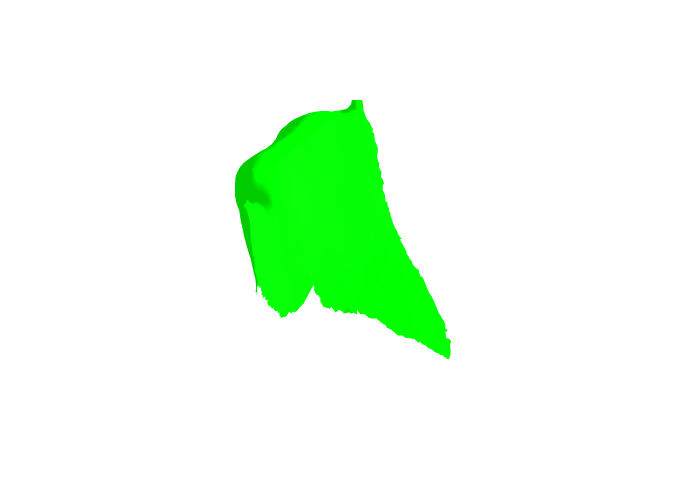

In [29]:
convert_plotly_fig_to_image(visualize_mesh(o3d.io.read_triangle_mesh("/home/shirshak/Teeth3DS_individual_teeth/individual_teeth/01ENPFHF_lower_fid31.obj"), color=np.array([0, 1, 0])))

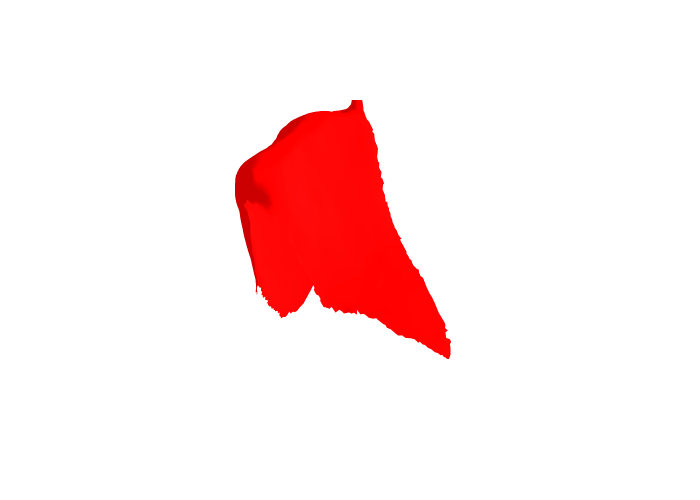

In [30]:
mesh_images_files[0]

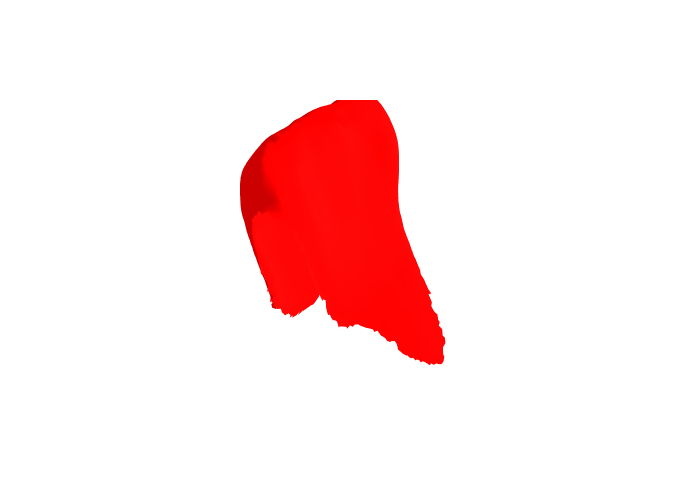

In [31]:
mesh_images_files[1]

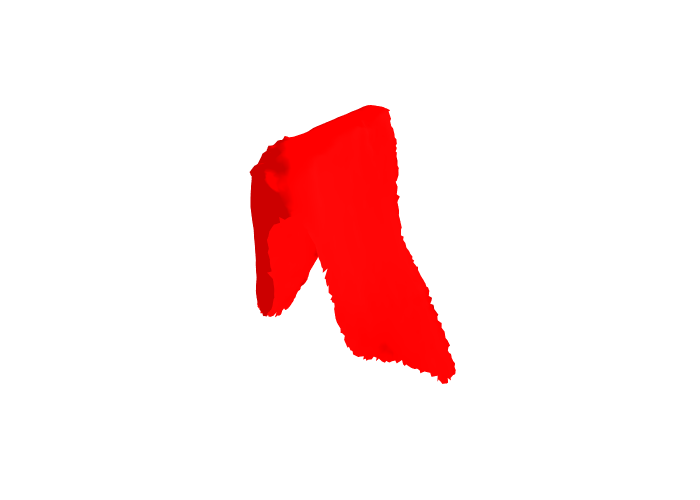

In [32]:
mesh_images_files[3]

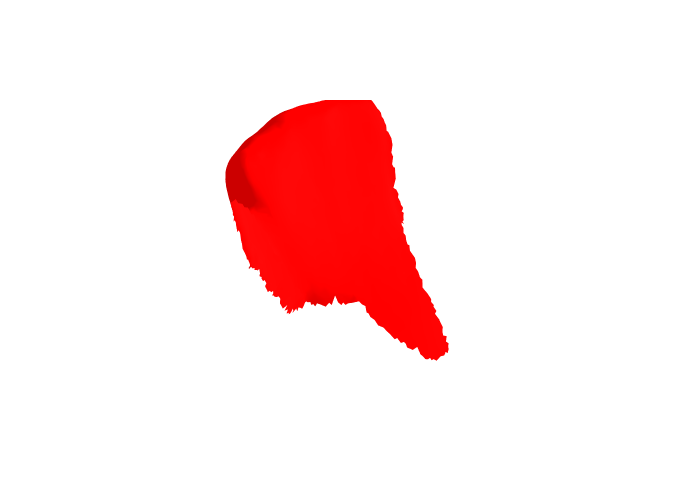

In [33]:
mesh_images_files[4]